In [108]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from imblearn.over_sampling import SMOTE

from autograd import grad
import autograd.numpy as np

# Reading the data
df = pd.read_csv("Non_Textual_and_Textual_Features.csv")

# Function to create labels based on the Boolean columns BUG and BIC of the dataset. 
def label_bool(is_bug,bic):
    if(is_bug==1 and bic==1):
        return 1 # Intrinsic
    elif(is_bug==1 and bic==0):
        return 0 # Extrinsic
    else:
        return -1 # Non-bug
    
df["Label"]=df.apply(lambda x: label_bool(x['BUG'],x['BIC']),axis=1)
df = df[df['Label']>-1] #Filtering out all non-bugs

df.head()

,Unnamed: 0.2,commit_id,author_date,bugcount,fixcount,la,ld,nf,nd,ns,...,BugId,Project,FixHashId,BUG,BIC,Comments,title,description,BFC_message,Label
0,0,0049967a874a3dca7c6ab8e8e84ca7dea21dc0b2,1395160653,0.0,1.0,29,12,2,2,1,...,1284162,neutron,0049967a874a3dca7c6ab8e8e84ca7dea21dc0b2,1,1,NaN,"Bug #1284162 in neutron: ""Cisco plugin fails t...",When the Cisco nexus plugin is configured on D...,Cisco plugin fails with ParseError no elem fou...,1
2,2,00ac56a100ac7329a01b5f1fa336b99e64778eaf,1401120475,NaN,1.0,16,4,4,3,1,...,1322180,nova,00ac56a100ac7329a01b5f1fa336b99e64778eaf,1,0,"""Legacy bdm in incoming parameters contains a ...","Bug #1322180 in OpenStack Compute (nova): ""Fai...",Launting an instance from bootable volume pass...,Run instance root device determination fix.\n\...,0
3,3,00f5125745dc72afbc9aeade8b780d7a3be49a30,1394439616,NaN,1.0,5,1,2,2,1,...,1288926,nova,00f5125745dc72afbc9aeade8b780d7a3be49a30,1,1,bug rebooting,"Bug #1288926 in OpenStack Compute (nova): ""inc...",This is using the latest nova from trunk. In o...,Don't allow reboot when instance in rebooting_...,1
4,4,011d99f300ea5d5f4ce48023bd04a795a4872287,1369792347,3.0,1.0,87,47,2,2,1,...,1175695,neutron,011d99f300ea5d5f4ce48023bd04a795a4872287,1,1,,"Bug #1175695 in neutron: ""L3 agent restart cau...","When L3 agent is restarted, it destroys all ex...",L3 Agent restart causes network outage\n\nWhen...,1
5,5,0125cf7815acb677b619905e2d9d258a9bae1c48,1407713999,NaN,1.0,3,2,2,2,1,...,1355759,neutron,0125cf7815acb677b619905e2d9d258a9bae1c48,1,1,NaN,"Bug #1355759 in neutron: ""L2populationRpcCallB...",L2populationRpcCallBackTunnelMixin get_agent_p...,"l2pop: get_agent_ports: Don't yield (None, {})...",1


# Data Clean up and processing

- Converting boolean columns values to either 1 (true) or 0 (false)
- Replacing NaN Values by zero (0)
- Normalizing the data (scaling it down twice)
- Defining the Independent and dependent variable

In [109]:
# Converting boolean columns to 1 and 0
df['revd'] = df['revd'].apply(lambda x: 1 if x==True else 0)
df['self'] = df['self'].apply(lambda x: 1 if x==True else 0)

#Feature selection 3:33 all featurs
print(df.columns[3:33])
columns=list(df.columns[3:33])

# Defining x and y
x = df[columns]
y = df['Label']

x = x.fillna(0)                                  # Replacing NaN values with the mean of that column
x_norm = (x-x.min())/(x.max()-x.min())*2      # Normalizing the data
x= x_norm

# Converting to numpy array
x = np.array(x)
y = np.array(y)

Index(['bugcount', 'fixcount', 'la', 'ld', 'nf', 'nd', 'ns', 'ent', 'revd',
       'nrev', 'rtime', 'tcmt', 'hcmt', 'self', 'ndev', 'age', 'nuc', 'app',
       'aexp', 'rexp', 'oexp', 'arexp', 'rrexp', 'orexp', 'asexp', 'rsexp',
       'osexp', 'asawr', 'rsawr', 'osawr'],
      dtype='object')


# Train Test Splitting the dataset

In [110]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)
print(x_train.shape, y_train.shape)

(892, 30) (892,)


In [119]:
def model(x,w):
    # generate polynomial function of degree = d
    polynomial_features = PolynomialFeatures(d)
    x_poly = polynomial_features.fit_transform(x)
    return np.dot(x_poly,w)  # x_poly already has the bias term within it
    #return w[0]+np.dot(x_poly,w[1:])

def sigmoid(t):
    return 1/(1+np.exp(-t)) 

def tanh(t):      # Experimenting with another activation function
    return (2/(1+np.exp(-2*t))) - 1

def cross_entropy(w,x,y):
    a = sigmoid(model(x,w))
    ind = np.argwhere(y==0)[:,0]
    cost = -5*np.sum(np.log(1-a[ind]))
    
    ind = np.argwhere(y==1)[:,0]
    cost -= np.sum(np.log(a[ind]))
    cost = cost/y.size
    cost += lambda_*norm(w[1:],1)
    return cost

# def class_balancing(X, y):
#     # Perform class balancing using SMOTE
#     smote = SMOTE()
#     X_balanced, y_balanced = smote.fit_resample(X, y)
#     return X_balanced, y_balanced


def gradient_descent(g,step,max_iter,w):
    gradient = grad(g)
    weight_history = [w]
    cost_history = [g(w)]
    
    for k in range(max_iter):
        grad_eval = gradient(w) #get the gradient
        grad_eval_norm = grad_eval/np.linalg.norm(grad_eval)  #Normalized gradient descent
        w = w - step*grad_eval_norm
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history, cost_history

def c(w):
    c = cross_entropy(w,x_train,y_train)
    return c

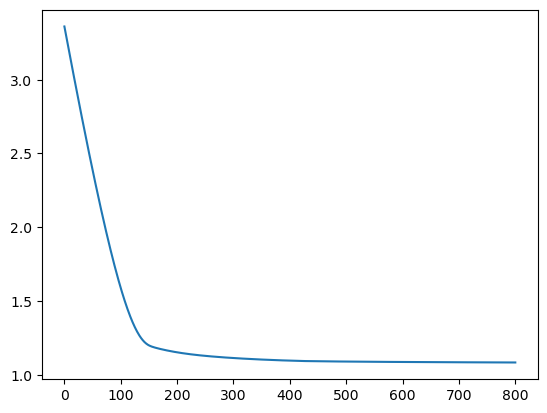

In [112]:
iter = 800

global d, lambda_

d = 1 #degree of polynomial
lambda_= 0
polynomial_features = PolynomialFeatures(d)
x_poly = polynomial_features.fit_transform(x)

# Training using gradient descent
w = np.array(np.random.rand(x_poly.shape[1],1))
a, b = gradient_descent(c,0.01,iter,w)

plt.plot(b) # Plot the cost minimization pattern

In [113]:
y_pred = np.sign(sigmoid(model(x_test, a[iter]))- 0.5)/2 +0.5

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[ 23  47]
 [116 254]]
0.6295454545454545
              precision    recall  f1-score   support

           0       0.17      0.33      0.22        70
           1       0.84      0.69      0.76       370

    accuracy                           0.63       440
   macro avg       0.50      0.51      0.49       440
weighted avg       0.74      0.63      0.67       440



In [118]:
# Comparing with the library method

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty='l2',solver='liblinear')
classifier.fit(x_train, y_train)

y_pred2 = classifier.predict(x_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))

[[  0  70]
 [  0 370]]
0.8409090909090909


# Experiments to analyze effect of regularization and sensitivity of data to Lambda value

In [120]:
# Splitting data into Train, Validation and Test

print(x.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42, stratify=y)
print(x_test.shape, y_test.shape)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=42, stratify=y_test)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1332, 30) (1332,)
(400, 30) (400,)
(932, 30) (932,)
(200, 30) (200,)
(200, 30) (200,)


[100.          89.44444444  78.88888889  68.33333333  57.77777778
  47.22222222  36.66666667  26.11111111  15.55555556   5.        ]
[0.01, 0.011180124223602485, 0.01267605633802817, 0.014634146341463412, 0.01730769230769231, 0.021176470588235293, 0.027272727272727268, 0.038297872340425525, 0.06428571428571428, 0.2]


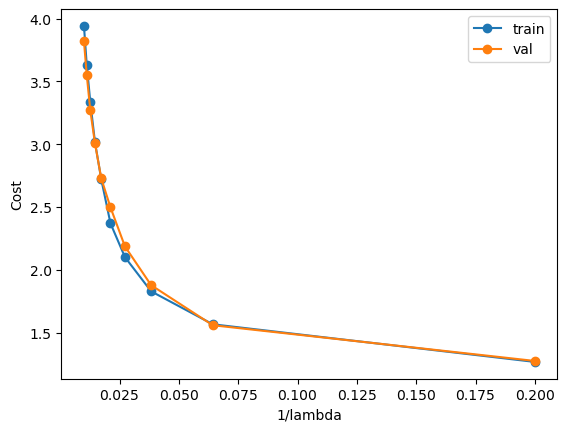

In [122]:
iter = 10000

global d, lambda_
d = 1
polynomial_features = PolynomialFeatures(d)
x_poly = polynomial_features.fit_transform(x)
w = np.array(np.random.rand(x_poly.shape[1],1))

lambda_array = np.linspace(100,5,10)
print(lambda_array)
cost_train_array = []
a_array = []
cost_val_array = []
i=0
for lambda_ in lambda_array:
    a, b = gradient_descent(c,0.01,iter,w)
    cost_val = cross_entropy(a[iter],x_val,y_val)
    a_array.append(a)
    cost_train_array.append(b[iter-1])
    cost_val_array.append(cost_val)
    
plt.figure(1)
lam = [1/x for x in lambda_array]
print(lam)

cost_train_array = np.array(cost_train_array)
cost_val_array = np.array(cost_val_array)
plt.plot(lam, cost_train_array, label="train", marker='o')
plt.plot(lam, cost_val_array, label="val", marker='o')
plt.xlabel('1/lambda')
plt.ylabel('Cost')
plt.legend()
plt.show()